In [1]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

In [2]:
# Inputs
contact_rate = 1.0
recovery_rate = 0.1
total_pop = 1000
inf_init = 12
n_particles = 100
observations = [0, 15, 40, 65, 124, 204, 252, 210]

# Updating particles
def predict_states(particles, contact_rate, recovery_rate, total_pop):
    updated_particles = np.empty_like(particles)
    suscept, infect, recovered = particles[:, 0], particles[:, 1], particles[:, 2]
    new_infections = np.random.binomial(suscept, 1.0 - np.exp(-contact_rate * infect / total_pop))
    new_recoveries = np.random.binomial(infect, 1.0 - np.exp(-recovery_rate))
 
    updated_particles[:, 0] = suscept - new_infections
    updated_particles[:, 1] = infect + new_infections - new_recoveries
    updated_particles[:, 2] = recovered + new_recoveries
 
    return updated_particles

# Calculation of importance weights
target_sd = 50.0
def get_importance(p_vals, mean):
    zero_trunc_vals = -p_vals / target_sd
    target = np.repeat(mean, n_particles)
    return truncnorm.pdf(target, zero_trunc_vals, np.inf, loc=p_vals, scale=target_sd)

def get_counts_from_particles(particles):
    melted_df = pd.DataFrame(particles).melt(var_name="Columns", value_name="Values")
    return melted_df.groupby(["Columns", "Values"]).size().reset_index(name="Counts")

# Plot results for number of infectious from output array
def plot_particle_results(prop_particles, resamp_particles):
    prop_counts = get_counts_from_particles(prop_particles[:, 1, :])
    resamp_counts = get_counts_from_particles(resamp_particles[:, 1, :])
    results_plot = plt.scatter(prop_counts["Columns"] - 0.2, prop_counts["Values"], s=prop_counts["Counts"] * 15.0, alpha=0.5, label="proposed")
    plt.scatter(resamp_counts["Columns"], resamp_counts["Values"], s=resamp_counts["Counts"] * 15.0, alpha=0.5, label="resampled")
    plt.scatter(range(1, len(observations) + 1), observations, label="target")
    plt.legend()
    return results_plot

def get_links_from_pedigree(particles, pedigree):
    links = []
    for t in range(len(observations)):
        for dest, origin in enumerate(pedigree[:, t]):
            links.append([t, t + 1, particles[origin, 1, t], particles[dest, 1, t + 1]])
    return np.array(links)

def plot_links(particles, pedigree, obs):
    links = get_links_from_pedigree(particles, pedigree)
    resamp_counts = get_counts_from_particles(particles[:, 1, :])
    links_plot = plt.scatter(resamp_counts["Columns"], resamp_counts["Values"], s=resamp_counts["Counts"] * 15.0, alpha=0.5, label="resampled")
    for i in range(len(links)):
        plt.plot([links[i, 0], links[i, 1]], [links[i, 2], links[i, 3]], color="k", linewidth=0.1)
    plt.scatter(range(1, len(obs) + 1), obs, label="target")
    return links_plot

In [3]:
# Initialise particles
particles = np.zeros([n_particles, 3, len(observations) + 1], dtype=int)
particles[:, 0, 0] = total_pop - inf_init  # Susceptible
particles[:, 1, 0] = inf_init  # Infectious
prop_particles = np.copy(particles)
pedigree = np.zeros([n_particles, len(observations)], dtype=int)

# Main loop
for o, obs in enumerate(observations):
    
    # Prediction
    proposed_particles = predict_states(particles[:, :, o], contact_rate, recovery_rate, total_pop)
    prop_particles[:, :, o + 1] = proposed_particles

    # Importance
    weights = get_importance(proposed_particles[:, 1], obs)
    norm_weights = weights / sum(weights)

    # Resampling
    indices = np.random.choice(n_particles, size=n_particles, p=norm_weights)
    pedigree[:, o] = indices
    resamp_particles = proposed_particles[indices]
    
    # Update
    particles[:, :, o + 1] = resamp_particles

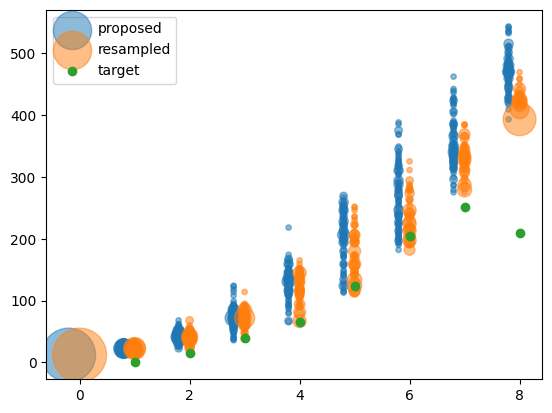

In [4]:
plot_particle_results(prop_particles, particles)

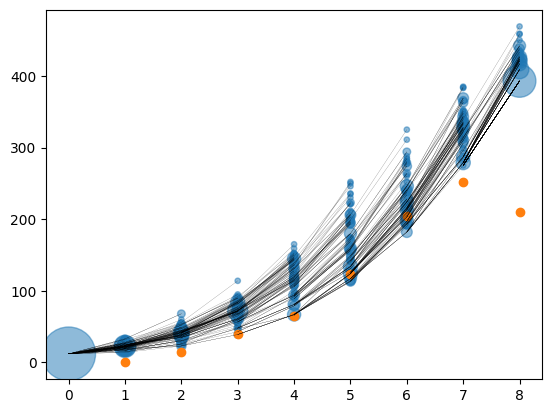

In [5]:
plot_links(particles, pedigree, observations)